<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [9]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [10]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [11]:
# Start coding here
# Use as many cells as you need.

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 1. Create and store the embeddings
review_series = reviews['Review Text'].dropna().astype(str)
review_text  = review_series.tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')
raw_embbedings = model.encode(
    review_text,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)
embeddings = raw_embbedings.tolist()

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

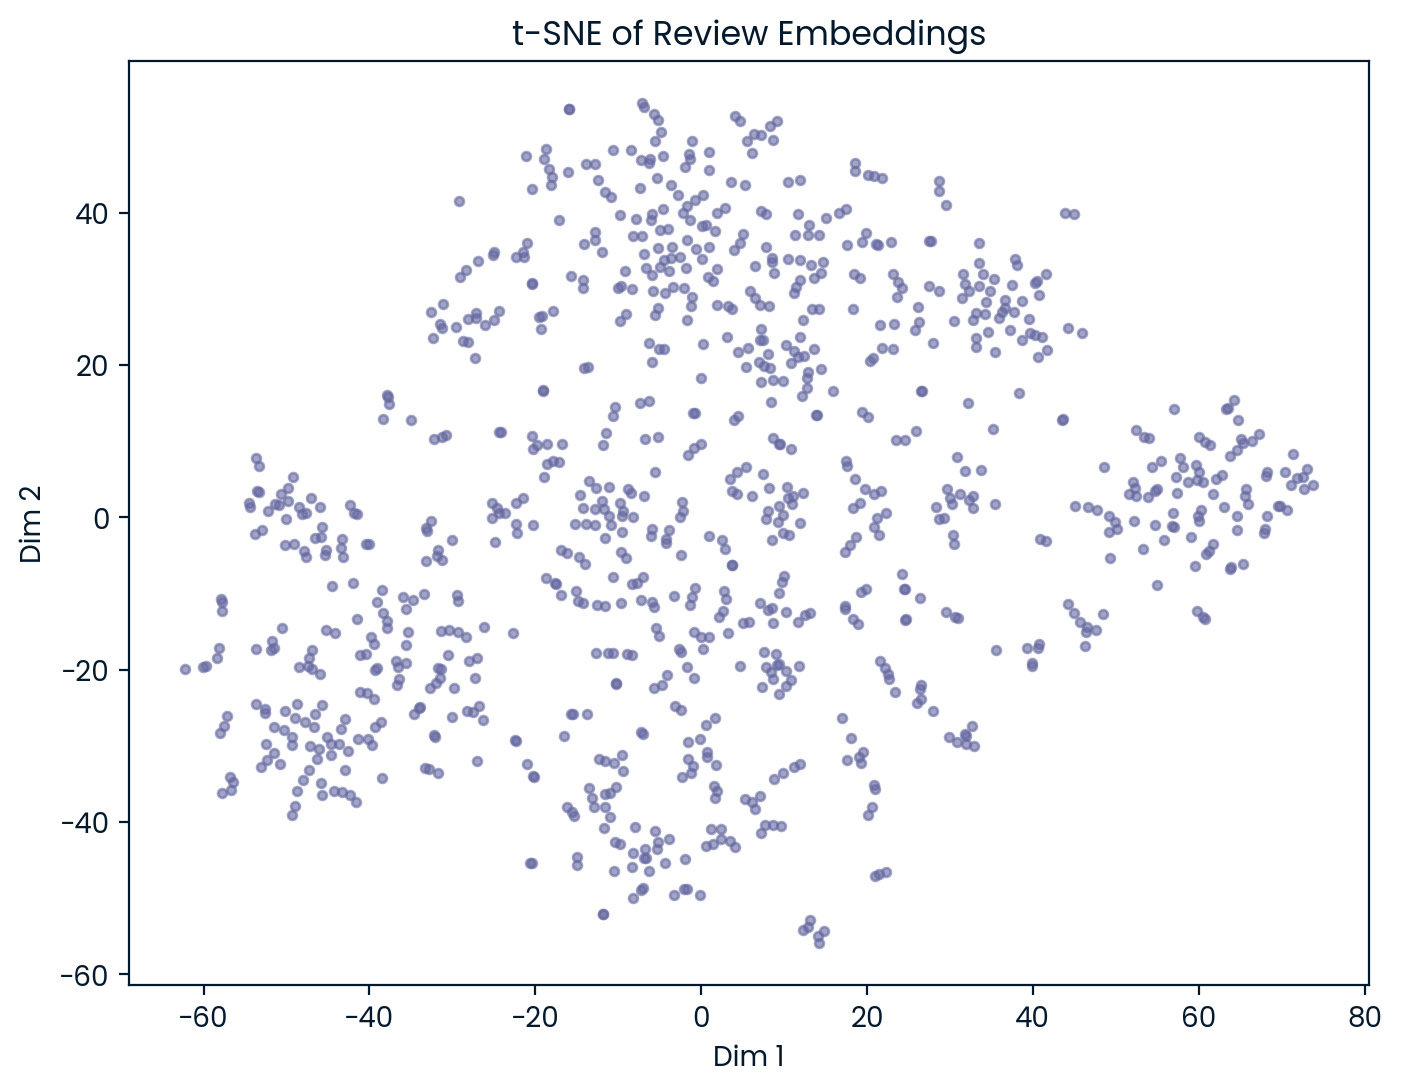

In [12]:
# 2. Dimensionality reduction and visualization

tsne = TSNE(n_components = 2, perplexity = 10, random_state=77, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(np.array(embeddings))

# Plot:
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], s=10, alpha=0.6)
plt.title("t-SNE of Review Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In [13]:
# 3. Feedback categorization

# Define your topics of interest:
topics = ["quality", "fit", "style", "comfort"]

# Embed those keywords with the *same* model:
topic_embeds = model.encode(topics, convert_to_numpy=True)

# For each review, pick the topic with highest cosine sim:
def cosine_sim(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

labels = []
for rev_emb in embeddings:
    sims = [cosine_sim(rev_emb, t_emb) for t_emb in topic_embeds]
    labels.append(topics[np.argmax(sims)])

# Add to your DataFrame:
reviews = reviews.loc[reviews['Review Text'].notna()].reset_index(drop=True)
reviews['Topic'] = labels
print(reviews.head())

   Review ID  Clothing ID  Age  ... Department Name Class Name    Topic
0          0          767   33  ...        Intimate  Intimates  comfort
1          1         1080   34  ...         Dresses    Dresses      fit
2          2         1077   60  ...         Dresses    Dresses  comfort
3          3         1049   50  ...         Bottoms      Pants    style
4          4          847   47  ...            Tops    Blouses    style

[5 rows x 12 columns]


In [14]:
# 4. Similarity search function using ChromaDB
import chromadb
from chromadb.config import Settings

# Spin up a Chroma client & collection
client = chromadb.Client(Settings())
col = client.create_collection(
    name="reviews_collections",
    metadata={"hnsw:space": "cosine"}  # use cosine distance in HNSW index
)

# Add your reviews
ids       = [str(i) for i in range(len(review_text))]
metadatas = [{"topic": t} for t in reviews["Topic"].tolist()]  # optional metadata
col.add(
    embeddings=raw_embbedings.tolist(),
    documents=review_text,
    ids=ids,
    metadatas=metadatas,
)

# Define a helper to query the top-k nearest reviews
def most_similar_chroma(query: str, k: int = 3):
    q_emb = model.encode([query], convert_to_numpy=True).tolist()
    results = col.query(
        query_embeddings=q_emb,
        n_results=k
    )
    docs = results["documents"][0]
    return list(docs)

# Try it out
query = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = most_similar_chroma(query, k=3)
print("Top 3 similar reviews via ChromaDB:")
for i, text in enumerate(most_similar_reviews, 1):
    print(f"{i}. {text}")

Top 3 similar reviews via ChromaDB:
1. Absolutely wonderful - silky and sexy and comfortable
2. Very comfortable and versatile. got lots of compliments.
3. Very cute, very comfortable. for me aesthetics and comfort must go hand in hand. this dress fits the bill.


In [15]:
# Similarity search function using cosine‐based nearest‐neighbors index:
nbrs = NearestNeighbors(n_neighbors=4, metric='cosine').fit(embeddings)

def most_similar_reviewss(query: str, k: int = 3) -> list[str]:
    """
    Returns up to k reviews (strings) most similar to `query`.
    """
    q_emb = model.encode([query], convert_to_numpy=True)[0]
    dists, idxs = nbrs.kneighbors([q_emb])
    out = []
    for idx in idxs[0]:
        cand = reviews.at[idx, 'Review Text']
        if cand != query:
            out.append(cand)
        if len(out) == k:
            break
    return out

# Apply to the first review:
query = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews2 = most_similar_reviewss(query, k=3)

print("Most similar reviews:")
for i, r in enumerate(most_similar_reviews2, 1):
    print(f"{i}. {r}")

Most similar reviews:
1. Very comfortable and versatile. got lots of compliments.
2. Very cute, very comfortable. for me aesthetics and comfort must go hand in hand. this dress fits the bill.
3. Cute and comfortable! i loved the colors and how soft the shirt is!
